In [1]:
import pandas as pd
import numpy as np

import sys

import configparser

import geopandas as gpd
import shapely


from fluxdataqaqc import Data, QaQc, Plot

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
#sys.path.append("//")
sys.path.append("../../../Micromet")
import micromet
from micromet import AmerifluxDataProcessor
%matplotlib inline

In [3]:
from pyproj import Transformer
EPSG = 5070
# load initial flux data
station = 'US-UTW'
config_path = f'../../station_config/{station}.ini'
config = configparser.ConfigParser()
config.read(config_path)

d = Data(config_path)
d.df.index.freq = '30min'
df = d.df.rename(columns=d.inv_map)
q = QaQc(d, daily_frac=3/4, max_interp_hours=4, max_interp_hours_night=6)

# make copies of daily results of different correction options
q.correct_data(meth='ebr', et_gap_fill=True)
ebr_gapfilled = q.df


latitude = config['METADATA']['station_latitude']
longitude = config['METADATA']['station_longitude']

# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG}", always_xy=True)

# Perform the transformation
station_x, station_y = transformer.transform(longitude, latitude)

print(f"Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X={station_x}, Y={station_y}")

Calculating mean for var: THETA from columns: ['SWC_1_1_1', 'SWC_2_1_1']
Converting vpd from hpa to kpa
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure

The input data temporal frequency appears to be less than daily.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 6 hours when Rn < 0 and up to 4 hours when Rn >= 0.


C:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Filtering days with less then 75.0% or 36/48 sub-daily measurements
gridMET reference ET already downloaded for station at:
C:\Users\paulinkenbrandt\Documents\GitHub\MicroMet\Notebooks\Footprints\..\..\station_config\gridMET_data\US-UTW_39.4417N_-110.7250W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)
Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X=-1251001.2763440341, Y=1921956.3381891234


In [9]:
data = pd.read_csv(config['METADATA']['climate_file_path'],
                   skiprows=int(config['METADATA']['skiprows']))
data['datetime_start'] = pd.to_datetime(data['datetime_start'])
data = data[(data['datetime_start'].dt.hour >= 6)&(data['datetime_start'].dt.hour <= 18)]

In [10]:
foot_xy = {}


#df = pd.read_csv("../../station_data/US-CdM_HH_202306141100_202410081700.csv")
for col in data.columns:
    if "fetch" in col.lower():
        data = micromet.polar_to_cartesian_dataframe(data, wd_column='WD',dist_column=col)

        data[f'X_{col}'] = data[f'X_{col}'] + station_x
        data[f'Y_{col}'] = data[f'Y_{col}'] + station_y

        foot_xy[col] = micromet.aggregate_to_daily_centroid(data,'datetime_start',f'X_{col}',f'Y_{col}',weighted=True)

daily_pnts = foot_xy['FETCH_55']
daily_pnts['geometry'] = gpd.points_from_xy(daily_pnts['X_FETCH_55'],
                                      daily_pnts['Y_FETCH_55'])
daily_pnts['date'] = pd.to_datetime(daily_pnts['Date'])
daily_pnts.drop(columns='Date', inplace=True)
daily_pnts.set_index('date', inplace=True)
daily_pnts = pd.concat([ebr_gapfilled, daily_pnts], axis=1)
daily_pnts_geo = gpd.GeoDataFrame(daily_pnts, geometry=daily_pnts.geometry)

data['ETpos'] = np.where(data['ET']>=0,data['ET'],np.nan)
#
data = data.set_index('datetime_start')

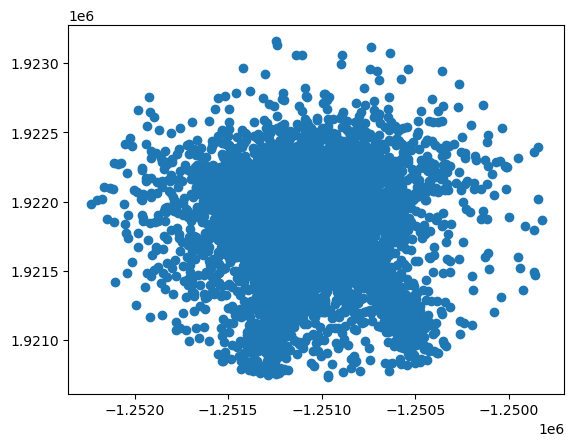

In [12]:
import matplotlib.pyplot as plt
plt.scatter(data['X_FETCH_55'],data['Y_FETCH_55'])

In [77]:
def plot_density_raster(density, transform, gdf, show_points=True):
    """
    Plots the density raster and overlays the input points.

    Parameters:
        density (numpy.ndarray): The rasterized density grid.
        transform (Affine): Raster transform for correct alignment.
        gdf (GeoDataFrame): The original point data to overlay.
    """

    # Get raster bounds
    xmin, ymax = transform.c, transform.f  # Top-left corner
    res = transform.a  # Cell size
    xmax = xmin + (density.shape[1] * res)
    ymin = ymax - (density.shape[0] * res)

    # Create the figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the density raster
    extent = [xmin, xmax, ymin, ymax]  # (left, right, bottom, top)
    im = ax.imshow(density, extent=extent, origin="upper", cmap="viridis", alpha=0.7)

    if show_points:
        # Overlay the input points
        gdf.plot(ax=ax, color="red", markersize=10, alpha=0.7, edgecolor="black")

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, label="Normalized Density")
    ax.set_title("Density Raster")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

    return fig, ax

In [58]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point



def concat_fetch_gdf(data, epsg=5070):
    dataxy = data.dropna(subset=['X_FETCH_90',
                               'Y_FETCH_90',
                               'X_FETCH_55',
                               'Y_FETCH_55',
                               'X_FETCH_40',
                               'Y_FETCH_40'],
                       how='any')

    dates = np.concatenate((dataxy.index.values, dataxy.index.values, dataxy.index.values))

    xs = np.concatenate((dataxy['X_FETCH_90'].values, dataxy['X_FETCH_55'].values, dataxy['X_FETCH_40'].values))
    ys = np.concatenate((dataxy['Y_FETCH_90'].values,  dataxy['Y_FETCH_55'].values,  dataxy['Y_FETCH_40'].values))

    weights = np.concatenate(([90]*len(dataxy['X_FETCH_90']),
                        [55]*len(dataxy['X_FETCH_55']),
                        [40]*len(dataxy['X_FETCH_40'])))

    # Create a DataFrame
    df = pd.DataFrame({'datetime_start':dates,
                       'x': xs,
                       'y': ys,
                       'weights': weights,
                       })

    df = df.set_index('datetime_start')

    dfday = df.groupby(pd.Grouper(freq='1D')).apply(
                    lambda g: pd.Series(
                        {
                            'x': (g['x'] * g["weights"]).sum() / g["weights"].sum(),
                            'y': (g['y'] * g["weights"]).sum() / g["weights"].sum(),
                            'weights': g['weights'].mean(),
                        }
                    )
                )

    # Convert to GeoDataFrame
    gdf_day = gpd.GeoDataFrame(dfday, geometry=[Point(xy) for xy in zip(dfday.x, dfday.y)])

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.x, df.y)])

    # Optionally set a CRS (e.g., WGS84)
    gdf_day = gdf_day.set_crs(epsg=epsg)
    gdf_day = gdf_day.dropna()

    gdf = gdf.set_crs(epsg=epsg)
    gdf = gdf.dropna()

    return gdf_day, gdf

In [61]:
for day in gdf_day.index.date:
    print(day)
#print(gdf.geometry.envelope)

2021-05-20
2021-05-21
2021-05-22
2021-05-23
2021-05-24
2021-05-25
2021-05-26
2021-05-27
2021-07-05
2021-07-06
2021-07-07
2021-07-08
2021-07-09
2021-07-10
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
2021-09-10
2021-09-11
2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
2021-09-17
2021-09-18
2021-09-19
2021-09-20
2021-09-21
2021-09-22
2021-09-23
2021-09-24
2021-09-25

In [88]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import xarray as xr
import rasterio.crs

epsg = 5070

gdf_day, gdf = concat_fetch_gdf(data,epsg=epsg)

res = 100

# List to hold KDE results for each day
kde_results = []

xmin = gdf.x.min()
xmax = gdf.x.max()
ymin = gdf.y.min()
ymax = gdf.y.max()

# Step 1: Create 2D grid
xvals = np.linspace(xmin, xmax, res)  # X range
yvals = np.linspace(ymin, ymax, res)  # Y range

X, Y = np.meshgrid(xvals, yvals)
positions = np.vstack([X.ravel(), Y.ravel()])

for day in gdf_day.index.date:
    hf_hr = gdf[gdf.index.date == day]
    m1 = hf_hr['x']
    m2 = hf_hr['y']

    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values, weights=hf_hr['weights'])
    Z = np.reshape(kernel(positions).T, X.shape)

    # Step 3: Compute 90th percentile threshold
    threshold_90 = np.percentile(Z, 90)

    # Step 4: Apply mask (set values > 90th percentile to NaN)
    Z_masked = np.where(Z > threshold_90, Z, np.nan)

    # Step 5: Normalize the masked values
    valid_sum = np.nansum(Z_masked)  # Sum only valid (non-NaN) values
    if valid_sum > 0:
        Z_normalized = Z_masked / valid_sum  # Normalize
    else:
        Z_normalized = Z_masked  # Avoid division by zero

    # Step 6: Create an xarray DataArray with georeferencing
    kde_da = xr.DataArray(
        Z_masked[:, :, np.newaxis],
        coords={'X': xvals,
                'Y': yvals,
                'time': [day],
                },  # Adjust for your coordinate system
        dims=['Y', 'X', 'time'],
        name='KDE',
    )

    # Optional: Assign CRS (WGS 84 for example)

    kde_da.attrs['crs'] = rasterio.crs.CRS.from_epsg(epsg)

    # Append the result to the list
    kde_results.append(kde_da)

# Concatenate all the daily KDE results along a new 'time' dimension
kde_da_all = xr.concat(kde_results, dim='time')

# Now 'kde_da_all' contains KDE results for each day, with 'time' as the new dimension
print(kde_da_all)


C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_28056\3574074342.py:37: RuntimeWarning: invalid value encountered in scalar divide
  'x': (g['x'] * g["weights"]).sum() / g["weights"].sum(),
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_28056\3574074342.py:38: RuntimeWarning: invalid value encountered in scalar divide
  'y': (g['y'] * g["weights"]).sum() / g["weights"].sum(),


<xarray.DataArray 'KDE' (Y: 100, X: 100, time: 1159)> Size: 93MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan,

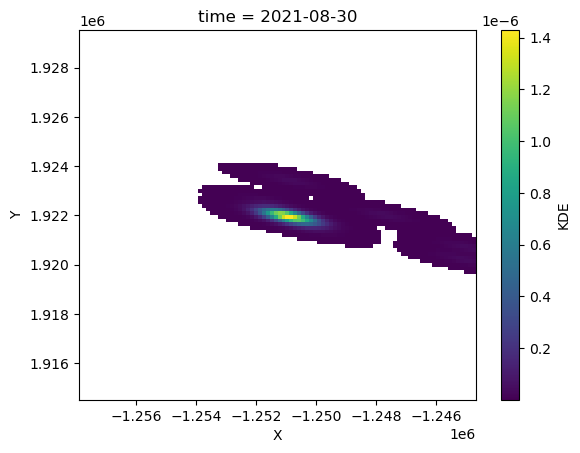

In [87]:
import datetime
kde_da_all.sel(time=datetime.date(2021, 8, 30)).plot()

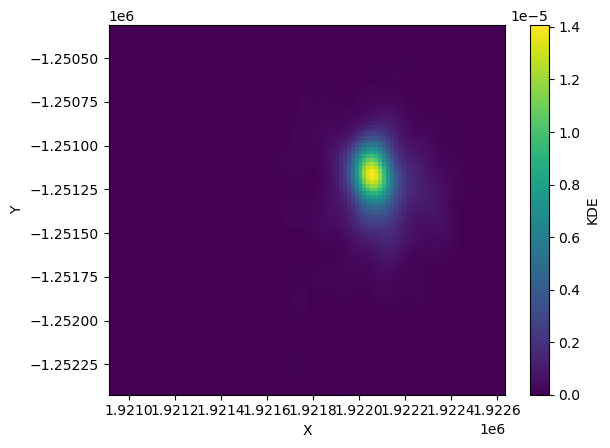

In [53]:
import numpy as np
import xarray as xr
from scipy.stats import gaussian_kde

# Example: List of dates (could be strings or datetime objects)
dates = ['2025-02-01', '2025-02-02', '2025-02-03']

# Example: Generate some random data points for each day (replace with actual data)
# For simplicity, we'll use random data; in your case, you would load the actual points for each day.
data_per_day = [np.random.randn(2, 1000) for _ in dates]

# Example grid for KDE (same grid for each day)
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
grid_x, grid_y = np.meshgrid(x, y)

# List to hold KDE results for each day
kde_results = []

# Loop over each day's data
for day, data in zip(dates, data_per_day):
    # Fit the KDE to the data for the day
    kde = gaussian_kde(data)
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()])
    kde_values = kde(grid_points).reshape(grid_x.shape)

    # Create a DataArray for the day and add it to the list
    kde_da_day = xr.DataArray(
        kde_values,
        coords=[('latitude', y), ('longitude', x), ],
        dims=['latitude', 'longitude'],
        name='KDE',
        attrs={'time': day}  # Add the time (or date) as an attribute
    )

    # Append the result to the list
    kde_results.append(kde_da_day)

# Concatenate all the daily KDE results along a new 'time' dimension
kde_da_all = xr.concat(kde_results, dim='time')

# Now 'kde_da_all' contains KDE results for each day, with 'time' as the new dimension
print(kde_da_all)


<Axes: >

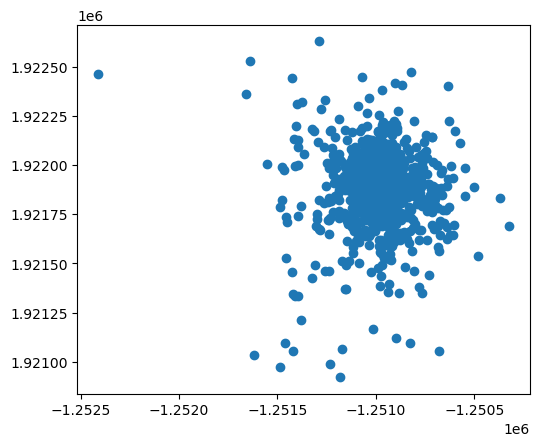

In [40]:
gdf.dropna().plot()#.plot()

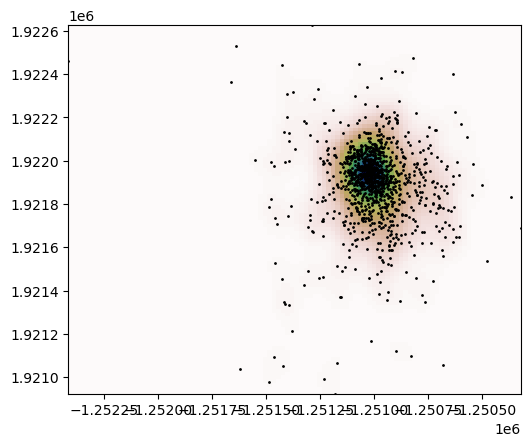

In [43]:


m1 = gdf['x']
m2 = gdf['y']

xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)


fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

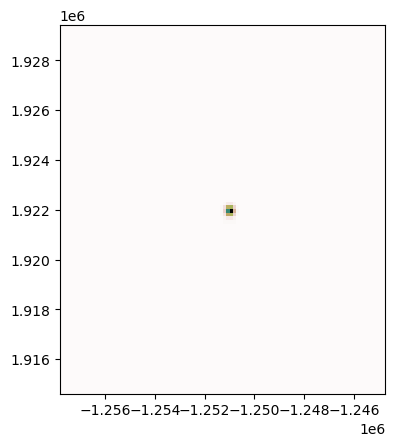

In [15]:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()


In [14]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from scipy.stats import gaussian_kde

data = data.dropna(subset=['X_FETCH_90',
                           'Y_FETCH_90',
                           'X_FETCH_55',
                           'Y_FETCH_55',
                           'X_FETCH_40',
                           'Y_FETCH_40'],
                   how='any')

xs = np.concatenate((data['X_FETCH_90'].values, data['X_FETCH_55'].values, data['X_FETCH_40'].values))
ys = np.concatenate((data['Y_FETCH_90'].values,  data['Y_FETCH_55'].values,  data['Y_FETCH_40'].values))
weights = np.concatenate(([90]*len(data['X_FETCH_90']),
                    [55]*len(data['X_FETCH_55']),
                    [40]*len(data['X_FETCH_40'])))


#buffer_distance = 0
resolution = 50

# Define raster extent with buffer
xmin = np.min(xs)
ymin = np.min(ys)
xmax = np.max(xs)
ymax = np.max(ys)

# Create a mesh grid
xgrid = np.arange(xmin, xmax, resolution)
ygrid = np.arange(ymin, ymax, resolution)
xmesh, ymesh = np.meshgrid(xgrid, ygrid)

# Perform KDE with weights
kde = gaussian_kde(np.vstack([xs, ys]), weights=weights)
density = kde(np.vstack([xmesh.ravel(), ymesh.ravel()])).reshape(xmesh.shape)

# Normalize to ensure sum of cell values is 1
#print(np.sum(density))
#density /= np.sum(density)

# Define raster transform
transform = from_origin(xmin, ymax, resolution, resolution)

In [87]:
xmin

np.float64(1929442.619503353)

In [15]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

data['geometry'] = gpd.points_from_xy(data['X_FETCH_55'],
                                      data['Y_FETCH_55'])

data_geo = gpd.GeoDataFrame(data, geometry=data.geometry, crs='EPSG:5070')
data_geo = data_geo.dropna(subset=['geometry','ETimp','X_FETCH_55','Y_FETCH_55'],how='any')

densitynorm = density / np.sum(density)

# Get raster bounds
xmin, ymax = transform.c, transform.f  # Top-left corner
res = transform.a  # Cell size
xmax = xmin + (density.shape[1] * res)
ymin = ymax - (density.shape[0] * res)

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the density raster
extent = [xmin, xmax, ymin, ymax]  # (left, right, bottom, top)
im = ax.imshow(densitynorm, extent=extent, origin="upper", cmap="viridis", alpha=0.7)
data_geo.plot(ax=ax, color="red", markersize=10, alpha=0.3, edgecolor="black")
print(extent)

# Add colorbar and labels
cbar = plt.colorbar(im, ax=ax, label="Normalized Density")
ax.set_title("Density Raster")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")


ax.scatter(station_x, station_y,color='red')
plt.xlim(xmin+5500, xmax-5500)
plt.ylim(ymin+6500, ymax-6500)

KeyError: ['ETimp']

In [14]:
import pandas as pd
import numpy as np

def impute_evapotranspiration(df, in_field='ET', out_field='ET'):
    """
    Impute missing data in a half-hourly evapotranspiration time series.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index and a column 'ET' containing evapotranspiration data.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed.
    """
    df = df.copy()  # Avoid modifying the original DataFrame

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Step 1: Linear interpolation for small gaps
    df[out_field] = df[in_field].interpolate(method='linear', limit=4)  # Limit to prevent long-term bias

    # Step 2: Seasonal and daily imputation
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['day_of_year'] = df.index.dayofyear

    # Compute typical ET values at the same time across different years
    daily_medians = df.groupby(['day_of_year', 'hour', 'minute'])[out_field].median()

    # Impute missing values using seasonal daily median
    def impute_from_medians(row):
        if pd.isna(row[out_field]):
            return daily_medians.get((row['day_of_year'], row['hour'], row['minute']), np.nan)
        return row[out_field]

    df[out_field] = df.apply(impute_from_medians, axis=1)

    # Step 3: Rolling mean smoothing to refine imputations
    df[out_field] = df[out_field].bfill().ffill()  # Handle any remaining NaNs
    df[out_field] = df[out_field].rolling(window=6, min_periods=1, center=True).mean()  # Smooth over 3 hours

    # Drop helper columns
    df.drop(columns=['hour', 'minute', 'day_of_year'], inplace=True)

    return df

# Example usage:
# df = pd.read_csv('evapotranspiration_data.csv', parse_dates=['datetime'], index_col='datetime')
# df = impute_evapotranspiration(df)

# df = pd.read_csv('evapotranspiration_data.csv', parse_dates=['datetime'], index_col='datetime')
# imputer = EvapotranspirationImputer(df)
# df_imputed = imputer.impute(method="seasonal_median")


<Axes: xlabel='datetime_start'>

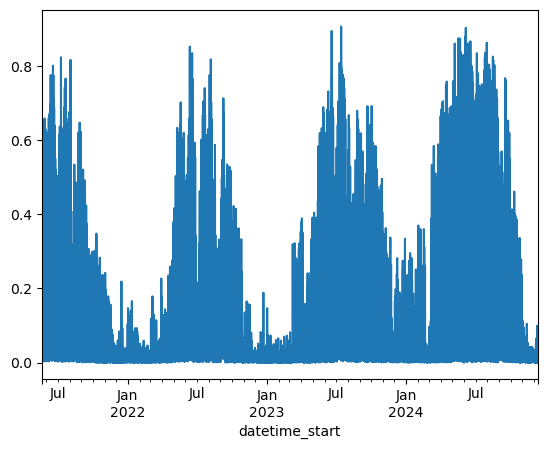

In [15]:
# df = pd.read_csv('evapotranspiration_data.csv', parse_dates=['datetime'], index_col='datetime')
data = impute_evapotranspiration(data,in_field='ETpos',out_field='ETimp')
#df_imputed = imputer.impute(method="seasonal_median")
data['ETimp'].plot()

In [60]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from scipy.stats import gaussian_kde


def generate_density_raster(
    gdf,
    resolution=50,  # Cell size in meters
    buffer_distance=200,  # Buffer beyond extent in meters
    epsg=5070,  # Default coordinate system
    weight_field="ET",
):
    """
    Generate a density raster from a point GeoDataFrame, weighted by the ET field.

    Parameters:
        gdf (GeoDataFrame): Input point GeoDataFrame with an 'ET' field.
        resolution (float): Raster cell size in meters (default: 50m).
        buffer_distance (float): Buffer beyond point extent (default: 200m).
        epsg (int): Coordinate system EPSG code (default: 5070).
        weight_field (str): Weight field name (default: ET).

    Returns:
        raster (numpy.ndarray): Normalized density raster.
        transform (Affine): Affine transformation for georeferencing.
        bounds (tuple): (xmin, ymin, xmax, ymax) of the raster extent.
    """

    # Ensure correct CRS
    gdf = gdf.to_crs(epsg=epsg)

    # Extract point coordinates and ET values
    x = gdf.geometry.x
    y = gdf.geometry.y
    weights = gdf[weight_field].values

    # Define raster extent with buffer
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xmin, xmax = xmin - buffer_distance, xmax + buffer_distance
    ymin, ymax = ymin - buffer_distance, ymax + buffer_distance

    # Create a mesh grid
    xgrid = np.arange(xmin, xmax, resolution)
    ygrid = np.arange(ymin, ymax, resolution)
    xmesh, ymesh = np.meshgrid(xgrid, ygrid)

    # Perform KDE with weights
    kde = gaussian_kde(np.vstack([x, y]), weights=weights)
    density = kde(np.vstack([xmesh.ravel(), ymesh.ravel()])).reshape(xmesh.shape)

    # Normalize to ensure sum of cell values is 1
    print(np.sum(density))
    density /= np.sum(density)

    # Define raster transform
    transform = from_origin(xmin, ymax, resolution, resolution)

    return density, transform, (xmin, ymin, xmax, ymax)

In [61]:
from scipy.stats import gaussian_kde

data['geometry'] = gpd.points_from_xy(data['X_FETCH_55'],
                                      data['Y_FETCH_55'])

data_geo = gpd.GeoDataFrame(data, geometry=data.geometry, crs='EPSG:5070')
data_geo = data_geo.dropna(subset=['geometry','ETimp','X_FETCH_55','Y_FETCH_55'],how='any')

density, transform, (xmin, ymin, xmax, ymax) = generate_density_raster(data_geo,
                                                                                resolution=10,
                                                                                buffer_distance=10,
                                                                                weight_field='ETimp')

0.009999980636374289


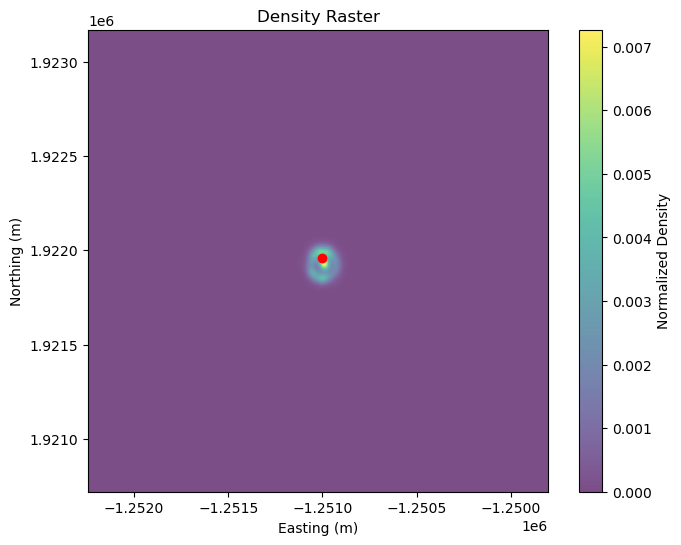

In [63]:
fig, ax = plot_density_raster(density,transform,data_geo,show_points=False)
ax.scatter(station_x, station_y,color='red')

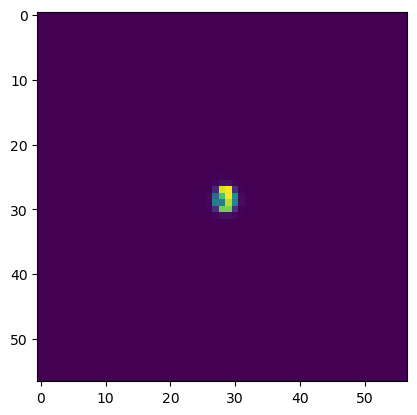

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(density)

In [19]:
data_geo

,TIMESTAMP_START,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,FC_SSITC_TEST,LE,LE_SSITC_TEST,...,Date,X_FETCH_90,Y_FETCH_90,X_FETCH_55,Y_FETCH_55,X_FETCH_40,Y_FETCH_40,ETpos,ETimp,geometry
datetime_start,,,,,,,,,,,,,,,,,,,,,
2021-05-20 08:30:00,202105200830,202105200900,407.2644,5.005207,7.278824,1.165805,-21.227040,-9999.0,204.42700,-9999.0,...,2021-05-20,-1.251029e+06,1.921996e+06,-1.251010e+06,1.921969e+06,-1.251007e+06,1.921965e+06,0.299065,0.356485,POINT (-1251009.939 1921968.923)
2021-05-20 09:00:00,202105200900,202105200930,407.7179,5.687793,6.741088,1.327115,-19.222810,-9999.0,219.14200,-9999.0,...,2021-05-20,-1.251101e+06,1.922063e+06,-1.251053e+06,1.922011e+06,-1.251040e+06,1.921998e+06,0.321098,0.401340,POINT (-1251052.644 1922011.151)
2021-05-20 09:30:00,202105200930,202105201000,406.3490,4.168286,6.139927,1.284270,-22.904720,-9999.0,306.05950,-9999.0,...,2021-05-20,-1.250991e+06,1.921819e+06,-1.250996e+06,1.921886e+06,-1.250997e+06,1.921903e+06,0.449293,0.450622,POINT (-1250995.775 1921885.772)
2021-05-20 10:00:00,202105201000,202105201030,406.7009,3.976950,5.667840,1.149024,-26.635310,-9999.0,364.80520,-9999.0,...,2021-05-20,-1.250972e+06,1.921820e+06,-1.250986e+06,1.921886e+06,-1.250990e+06,1.921903e+06,0.535903,0.467506,POINT (-1250986.046 1921885.984)
2021-05-20 10:30:00,202105201030,202105201100,406.4454,3.858029,5.672696,1.118326,-32.143910,-9999.0,440.80070,-9999.0,...,2021-05-20,-1.251012e+06,1.921810e+06,-1.251007e+06,1.921881e+06,-1.251005e+06,1.921899e+06,0.647750,0.497428,POINT (-1251006.78 1921880.917)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11 10:30:00,202412111030,202412111100,414.4312,0.986281,2.232887,0.135519,0.128185,-9999.0,25.45334,-9999.0,...,2024-12-11,-1.251022e+06,1.921947e+06,-1.251008e+06,1.921953e+06,-1.251006e+06,1.921954e+06,0.036570,0.030265,POINT (-1251008.139 1921953.116)
2024-12-11 11:00:00,202412111100,202412111130,416.2808,0.654022,2.306602,0.129379,0.028913,1.0,27.28709,1.0,...,2024-12-11,-1.250986e+06,1.922005e+06,-1.250996e+06,1.921972e+06,-1.250998e+06,1.921968e+06,0.039245,0.033272,POINT (-1250996.191 1921972.101)
2024-12-11 11:30:00,202412111130,202412111200,416.2424,0.481336,2.451435,0.112188,-0.123392,1.0,21.24795,1.0,...,2024-12-11,-1.250975e+06,1.921981e+06,-1.250993e+06,1.921964e+06,-1.250996e+06,1.921961e+06,0.030578,0.035636,POINT (-1250993.055 1921963.984)


In [8]:
daily_pnts.dropna(subset=['X_FETCH_55', 'ET'], inplace=True)
daily_pnts

,T_SONIC,WS,NETRAD,input_LE,input_G,LW_IN,vp,input_H,SWC_2_1_1,SW_OUT,...,gridMET_ETo,gridMET_prcp,ETrF,ETrF_filtered,ET_fill,ET_gap,ET_fill_val,X_FETCH_55,Y_FETCH_55,geometry
date,,,,,,,,,,,,,,,,,,,,,
2021-05-21,16.244161,6.048140,124.574898,98.342841,-10.112438,328.338150,0.499443,-47.461760,NaN,48.109834,...,6.0,0.0,0.653689,0.694108,6.316379,False,NaN,-1.250986e+06,1.921881e+06,POINT (-1250985.916 1921880.915)
2021-05-22,11.423597,3.179343,112.493020,66.862906,-6.982685,302.924508,0.270123,-7.109466,NaN,42.187538,...,5.8,0.0,0.476219,0.681883,5.796005,False,NaN,-1.250995e+06,1.921891e+06,POINT (-1250995.479 1921891.266)
2021-05-23,10.083562,4.053288,190.005219,92.610903,-0.125685,290.308333,0.384735,13.991777,NaN,59.294365,...,4.7,0.0,0.865302,0.698501,4.540258,False,NaN,-1.251029e+06,1.921913e+06,POINT (-1251028.731 1921912.625)
2021-05-24,11.356567,2.015652,246.568210,97.192030,8.458764,280.899615,0.439603,39.250973,22.707600,73.641898,...,5.6,0.0,0.781220,0.698501,5.308610,False,NaN,-1.251054e+06,1.921974e+06,POINT (-1251053.601 1921974.001)
2021-05-25,14.597245,2.047779,230.981100,87.220020,8.710010,307.123498,0.381739,19.460317,NaN,60.800114,...,6.6,0.0,0.632985,0.707464,6.437920,False,NaN,-1.250979e+06,1.921870e+06,POINT (-1250979.352 1921869.779)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06,-2.094009,1.327107,60.864713,8.750725,-11.538266,229.920392,0.298169,7.445892,17.849599,32.841341,...,1.2,0.0,NaN,0.210409,0.420817,True,0.420817,-1.251106e+06,1.921780e+06,POINT (-1251106.41 1921779.505)
2024-12-07,-2.035929,1.246510,48.148217,9.419875,-11.026119,231.866988,0.285078,10.297520,17.786217,35.216428,...,1.3,0.0,NaN,0.210409,0.462899,True,0.462899,-1.251078e+06,1.921837e+06,POINT (-1251077.536 1921836.541)
2024-12-08,-1.399945,1.164412,38.979891,7.075291,-9.869548,240.731246,0.299635,13.720887,NaN,NaN,...,1.3,0.0,NaN,0.210409,0.420817,True,0.420817,-1.251058e+06,1.921853e+06,POINT (-1251058.463 1921852.535)


In [9]:
# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:5070", f"EPSG:4326", always_xy=True)

for ind in daily_pnts.index:

    # Perform the transformation
    longitude, latitude = transformer.transform(f"{daily_pnts.loc[ind, 'X_FETCH_55']}",
                                                 f"{daily_pnts.loc[ind, 'Y_FETCH_55']}")

    print(longitude, latitude)
    #(EPSG:5070)



-110.72848551116428 39.444656224997104
-110.72861504532051 39.4447343137918
-110.72903895570305 39.444876809904066
-110.72943820058721 39.44538364081883
-110.7283893000335 39.44456709216269
-110.72929358786095 39.44519912435446
-110.72913346419621 39.445735187327365
-110.72873500347782 39.44460807620113
-110.7293077351122 39.445294323316354
-110.7295190071905 39.4449945600679
-110.72964067443796 39.44535664075058
-110.72910503965457 39.44512025779099
-110.72892387560857 39.44453692203364
-110.72865079583657 39.44509015549985
-110.72902402214808 39.44508182514803
-110.72894814885866 39.44511411210632
-110.72949666357975 39.4453504651526
-110.73017037199025 39.44541285068809
-110.72940300896403 39.445378074297075
-110.72933005249098 39.44528524401153
-110.72973925412695 39.445105270906794
-110.72939473228979 39.44507323672697
-110.7293917137673 39.44519236604792
-110.72978387651061 39.44564160955395
-110.72899790237922 39.444820928201736
-110.72904833891157 39.4454091464712
-110.72867041

In [10]:
import requests

keyconf_path = f'../../secrets/config.ini'
keyconf = configparser.ConfigParser()
keyconf.read(keyconf_path)

# set your API key before making the request
header = {"Authorization": keyconf['OPENET']['key']}

# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:5070", f"EPSG:4326", always_xy=True)


oet = {}
i = 0
for ind in daily_pnts.index[:]:

    # Perform the transformation
    longitude, latitude = transformer.transform(f"{daily_pnts.loc[ind, 'X_FETCH_55']}",
                                                 f"{daily_pnts.loc[ind, 'Y_FETCH_55']}")

    print(longitude, latitude)


    args = {
      "date_range": [
        f"{ind:%Y-%m-%d}",
        f"{ind+pd.Timedelta(days=1):%Y-%m-%d}"
      ],
      "file_format": "JSON",
      "geometry": [
        -121.36322,
        38.87626
      ],
      "interval": "daily",
      "model": "Ensemble",
      "reference_et": "gridMET",
      "units": "mm",
      "variable": "ET"
    }

    # query the api
    resp = requests.post(
        headers=header,
        json=args,
        url="https://openet-api.org/raster/timeseries/point"
    )

    if resp.status_code != 200:
        pass
    else:
        print(resp.json(),i)
        oet[ind] = resp.json()[0]['et']
    i+=1

-110.72848551116428 39.444656224997104
[{'time': '2021-05-21', 'et': 5.595}, {'time': '2021-05-22', 'et': 5.107}]
[{'time': '2021-05-21', 'et': 5.595}, {'time': '2021-05-22', 'et': 5.107}] 0
-110.72861504532051 39.4447343137918
[{'time': '2021-05-22', 'et': 5.107}, {'time': '2021-05-23', 'et': 6.354}]
[{'time': '2021-05-22', 'et': 5.107}, {'time': '2021-05-23', 'et': 6.354}] 1
-110.72903895570305 39.444876809904066
[{'time': '2021-05-23', 'et': 6.354}, {'time': '2021-05-24', 'et': 7.059}]
[{'time': '2021-05-23', 'et': 6.354}, {'time': '2021-05-24', 'et': 7.059}] 2
-110.72943820058721 39.44538364081883
[{'time': '2021-05-24', 'et': 7.059}, {'time': '2021-05-25', 'et': 7.956}]
[{'time': '2021-05-24', 'et': 7.059}, {'time': '2021-05-25', 'et': 7.956}] 3
-110.7283893000335 39.44456709216269
[{'time': '2021-05-25', 'et': 7.956}, {'time': '2021-05-26', 'et': 8.726}]
[{'time': '2021-05-25', 'et': 7.956}, {'time': '2021-05-26', 'et': 8.726}] 4
-110.72929358786095 39.44519912435446
[{'time': '2

In [20]:
config = configparser.ConfigParser()

config.read('../../secrets/config.ini')

from sqlalchemy import create_engine
import urllib.parse
host = config['DEFAULT']['ip']
pw = config['DEFAULT']['pw']
user = config['DEFAULT']['login']

encoded_password = urllib.parse.quote_plus(pw)

def postconn_et(encoded_password, host='localhost',user='postgres',port='5432',db='groundwater', schema = 'groundwater'):
    connection_text = "postgresql+psycopg2://{:}:{:}@{:}:{:}/{:}?gssencmode=disable".format(user,encoded_password,host,port,db)
    return create_engine(connection_text, connect_args={'options': '-csearch_path={}'.format(schema)})


engine = postconn_et(encoded_password, host=host, user=user)

In [33]:
daily_pnts['openet_ens_mm'] = daily_pnts.index.map(oet)
daily_pnts['stationid'] = 'US-UTW'
daily_pnts_no_geo = daily_pnts.drop(['geometry'], axis=1)
daily_pnts_no_geo.to_parquet("G:/Shared drives/UGS_Flux/Data_Processing/Wellington/daily_footprint_pnts.parquet")
daily_pnts_no_geo.to_sql('daily_et',engine,if_exists='append', index=False)


ProgrammingError: (psycopg2.errors.InvalidSchemaName) schema "np" does not exist
LINE 1: ...31666666, 134.68733520833334, 1.7240835019153715, np.float64...
                                                             ^

[SQL: INSERT INTO daily_et ("T_SONIC", "WS", "NETRAD", "input_LE", "input_G", "LW_IN", vp, "input_H", "SWC_2_1_1", "SW_OUT", theta_mean, "RH_1_1_1", t_dew, "SW_IN", "VPD", "SWC_1_1_1", "WD", es, "LW_OUT", t_min, t_max, "LE_subday_gaps", "Rn_subday_gaps", " ... 595738 characters truncated ... ll_val__653)s, %(X_FETCH_55__653)s, %(Y_FETCH_55__653)s, %(openet_ens_mm__653)s, %(stationid__653)s)]
[parameters: {'SW_OUT__0': 48.10983362973684, 'RH_1_1_1__0': 25.622742666666667, 'LW_OUT__0': 386.95647291666666, 'NETRAD__0': 124.57489754166666, 'rso__0': 366.45353330465883, 'gridMET_ETr__0': 9.1, 'ET_fill_val__0': None, 'ebr_5day_clim__0': np.float64(0.5800183105337122), 'H_corr__0': -81.82803809905135, 'T_SONIC__0': 16.244160583333333, 'DOY__0': 141, 'gridMET_prcp__0': 0.0, 'ebr__0': 0.37777182418795496, 'ETrF_filtered__0': 0.6941075759474127, 'VPD__0': 1.37080888125, 'ET__0': 3.450279145437267, 'LW_IN__0': 328.33815, 'WD__0': 164.45262083333333, 'WS__0': 6.048139854166667, 'ETrF__0': 0.6536889397418746, 'LE_subday_gaps__0': 0.0, 'input_G__0': -10.112437666666667, 'ebr_corr__0': 0.5800183105337122, 'G_subday_gaps__0': 0.0, 'es__0': 1.8702517324475592, 'energy__0': 134.68733520833334, 't_max__0': 19.971, 'input_LE__0': 98.34284072916667, 'vp__0': 0.49944285119755927, 'SW_IN__0': 200.63959431708335, 'flux_corr__0': 87.72323113359593, 't_min__0': 9.420147, 'ET_corr__0': 5.9485693516510585, 'Rn_subday_gaps__0': 0.0, 'input_H__0': -47.461760412500006, 'ET_fill__0': 6.316378941121455, 'flux__0': 50.88108031666666, 'openet_ens_mm__0': 5.595, 'gridMET_ETo__0': 6.0, 'ebc_cf__0': 1.7240835019153715, 'Y_FETCH_55__0': 1921880.9146862684, 't_dew__0': -5.606450678743251, 'ET_gap__0': False, 'X_FETCH_55__0': -1250985.9162531097, 'stationid__0': 'US-UTW', 'LE_corr__0': 169.5512692326473, 'H_subday_gaps__0': 0.0, 'SWC_1_1_1__0': None, 'SWC_2_1_1__0': None, 'theta_mean__0': None ... 32600 parameters truncated ... 'SW_OUT__653': 71.48206178522727, 'RH_1_1_1__653': 24.683905416666665, 'LW_OUT__653': 421.0104979166667, 'NETRAD__653': 287.53592791666665, 'rso__653': 375.68383146487173, 'gridMET_ETr__653': 9.9, 'ET_fill_val__653': None, 'ebr_5day_clim__653': np.float64(0.5486469939187506), 'H_corr__653': -42.37651520130323, 'T_SONIC__653': 23.975494166666667, 'DOY__653': 187, 'gridMET_prcp__653': 0.0, 'ebr__653': 0.5153620207518316, 'ETrF_filtered__653': 1.0087652104279898, 'VPD__653': 2.3579668166666665, 'ET__653': 6.013264134965515, 'LW_IN__653': 350.41756250000003, 'WD__653': 210.79007784583334, 'WS__653': 2.029014, 'ETrF__653': 1.2131271882593169, 'LE_subday_gaps__653': 0.0, 'input_G__653': -1.401443916666666, 'ebr_corr__653': 0.5006898069318079, 'G_subday_gaps__653': 0.0, 'es__653': 3.150026664501587, 'energy__653': 288.9373718333333, 't_max__653': 31.75719, 'input_LE__653': 170.12483703333334, 'vp__653': 0.7920598478349207, 'SW_IN__653': 379.62684531229166, 'flux_corr__653': 297.4043924146246, 't_min__653': 13.96251, 'ET_corr__653': 12.009959163767238, 'Rn_subday_gaps__653': 0.0, 'input_H__653': -21.217489214583335, 'ET_fill__653': 9.9867755832371, 'flux__653': 148.90734781875, 'openet_ens_mm__653': 7.109, 'gridMET_ETo__653': 7.300000000000001, 'ebc_cf__653': 1.9972445736970963, 'Y_FETCH_55__653': 1921943.9088134125, 't_dew__653': 3.283219440537387, 'ET_gap__653': False, 'X_FETCH_55__653': -1251041.9799284851, 'stationid__653': 'US-UTW', 'LE_corr__653': 339.78090761592784, 'H_subday_gaps__653': 0.0, 'SWC_1_1_1__653': 29.282763513513515, 'SWC_2_1_1__653': 26.259708604651166, 'theta_mean__653': 27.899464166666665}]
(Background on this error at: https://sqlalche.me/e/20/f405)

In [25]:
daily_pnts_geo.index

DatetimeIndex(['2021-05-20', '2021-05-21', '2021-05-22', '2021-05-23',
               '2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27',
               '2021-05-28', '2021-05-29',
               ...
               '2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05',
               '2024-12-06', '2024-12-07', '2024-12-08', '2024-12-09',
               '2024-12-10', '2024-12-11'],
              dtype='datetime64[ns]', name='date', length=1302, freq='D')

ProgrammingError: (psycopg2.ProgrammingError) can't adapt type 'Point'
[SQL: INSERT INTO daily ("T_SONIC", "WS", "NETRAD", "input_LE", "input_G", "LW_IN", vp, "input_H", "SWC_2_1_1", "SW_OUT", theta_mean, "RH_1_1_1", t_dew, "SW_IN", "VPD", "SWC_1_1_1", "WD", es, "LW_OUT", t_min, t_max, "LE_subday_gaps", "Rn_subday_gaps", "G_s ... 595867 characters truncated ... FETCH_55__640)s, %(Y_FETCH_55__640)s, %(geometry__640)s, %(openet_ens_mm__640)s, %(stationid__640)s)]
[parameters: {'SW_OUT__0': 48.10983362973684, 'RH_1_1_1__0': 25.622742666666667, 'LW_OUT__0': 386.95647291666666, 'NETRAD__0': 124.57489754166666, 'rso__0': 366.45353330465883, 'gridMET_ETr__0': 9.1, 'ET_fill_val__0': None, 'ebr_5day_clim__0': np.float64(0.5800183105337122), 'H_corr__0': -81.82803809905135, 'T_SONIC__0': 16.244160583333333, 'DOY__0': 141, 'gridMET_prcp__0': 0.0, 'ebr__0': 0.37777182418795496, 'ETrF_filtered__0': 0.6941075759474127, 'VPD__0': 1.37080888125, 'ET__0': 3.450279145437267, 'LW_IN__0': 328.33815, 'WD__0': 164.45262083333333, 'WS__0': 6.048139854166667, 'ETrF__0': 0.6536889397418746, 'LE_subday_gaps__0': 0.0, 'input_G__0': -10.112437666666667, 'ebr_corr__0': 0.5800183105337122, 'G_subday_gaps__0': 0.0, 'es__0': 1.8702517324475592, 'energy__0': 134.68733520833334, 't_max__0': 19.971, 'input_LE__0': 98.34284072916667, 'vp__0': 0.49944285119755927, 'SW_IN__0': 200.63959431708335, 'flux_corr__0': 87.72323113359593, 't_min__0': 9.420147, 'ET_corr__0': 5.9485693516510585, 'Rn_subday_gaps__0': 0.0, 'input_H__0': -47.461760412500006, 'ET_fill__0': 6.316378941121455, 'flux__0': 50.88108031666666, 'openet_ens_mm__0': 5.595, 'gridMET_ETo__0': 6.0, 'ebc_cf__0': 1.7240835019153715, 'Y_FETCH_55__0': 1921880.9146862684, 't_dew__0': -5.606450678743251, 'ET_gap__0': False, 'X_FETCH_55__0': -1250985.9162531097, 'geometry__0': <POINT (-1250985.916 1921880.915)>, 'stationid__0': 'US-UTW', 'LE_corr__0': 169.5512692326473, 'H_subday_gaps__0': 0.0, 'SWC_1_1_1__0': None, 'SWC_2_1_1__0': None ... 32591 parameters truncated ... 'RH_1_1_1__640': 21.140928354166665, 'LW_OUT__640': 381.44391666666667, 'NETRAD__640': 286.6775758333333, 'rso__640': 379.49119225034485, 'gridMET_ETr__640': 12.0, 'ET_fill_val__640': None, 'ebr_5day_clim__640': np.float64(0.5615365003177153), 'H_corr__640': -32.10186593768988, 'T_SONIC__640': 17.4349305625, 'DOY__640': 174, 'gridMET_prcp__640': 0.0, 'ebr__640': 0.4971856109726399, 'ETrF_filtered__640': 0.7912190955007835, 'VPD__640': 1.7285609583333335, 'ET__640': 5.726785523024779, 'LW_IN__640': 301.29950625, 'WD__640': 213.52961104166664, 'WS__640': 3.70978935, 'ETrF__640': 0.9346995780472326, 'LE_subday_gaps__640': 0.0, 'input_G__640': -8.288946375, 'ebr_corr__640': 0.5105727424374806, 'G_subday_gaps__640': 0.0, 'es__640': 2.103583909998258, 'energy__640': 294.96652220833334, 't_max__640': 24.58763, 'input_LE__640': 163.04344828979166, 'vp__640': 0.3750229516649248, 'SW_IN__640': 397.18343077083335, 'flux_corr__640': 287.2325495883333, 't_min__640': 7.749937, 'ET_corr__640': 11.216394936566791, 'Rn_subday_gaps__640': 0.0, 'input_H__640': -16.390337729166667, 'ET_fill__640': 9.494629146009402, 'flux__640': 146.65311056062498, 'openet_ens_mm__640': 5.993, 'gridMET_ETo__640': 8.200000000000001, 'ebc_cf__640': 1.958584775258443, 'Y_FETCH_55__640': 1921920.292505147, 't_dew__640': -7.916731574530741, 'ET_gap__640': False, 'X_FETCH_55__640': -1251046.5321801791, 'geometry__640': <POINT (-1251046.532 1921920.293)>, 'stationid__640': 'US-UTW', 'LE_corr__640': 319.3344155260232, 'H_subday_gaps__640': 0.0, 'SWC_1_1_1__640': None, 'SWC_2_1_1__640': None, 'theta_mean__640': None}]
(Background on this error at: https://sqlalche.me/e/20/f405)

In [30]:
daily_pnts['openet_ens_mm'] = daily_pnts.index.map(oet)
daily_pnts['stationid'] = 'US-UTW'

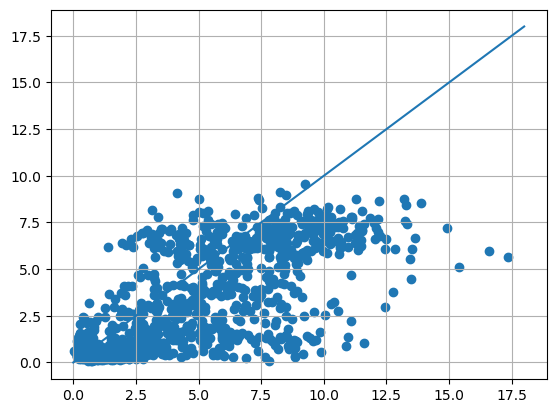

In [17]:
import matplotlib.pyplot as plt
plt.scatter(daily_pnts['ET_fill'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()


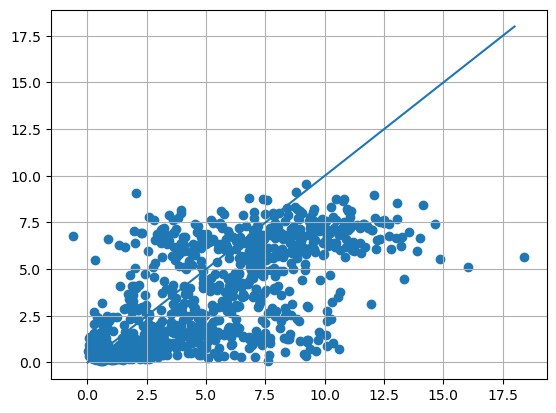

In [18]:
plt.scatter(daily_pnts['ET_corr'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()

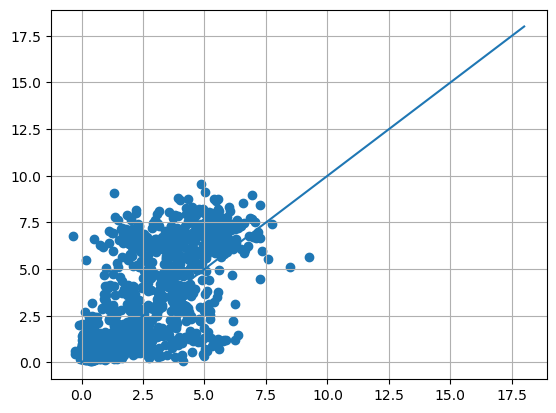

In [19]:
plt.scatter(daily_pnts['ET'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from scipy.stats import gaussian_kde

def generate_density_raster(
    gdf,
    resolution=50,  # Cell size in meters
    buffer_distance=200,  # Buffer beyond extent in meters
    epsg=5070  # Default coordinate system
):
    """
    Generate a density raster from a point GeoDataFrame, weighted by the ET field.

    Parameters:
        gdf (GeoDataFrame): Input point GeoDataFrame with an 'ET' field.
        resolution (float): Raster cell size in meters (default: 50m).
        buffer_distance (float): Buffer beyond point extent (default: 200m).
        epsg (int): Coordinate system EPSG code (default: 5070).

    Returns:
        raster (numpy.ndarray): Normalized density raster.
        transform (Affine): Affine transformation for georeferencing.
        bounds (tuple): (xmin, ymin, xmax, ymax) of the raster extent.
    """

    # Ensure correct CRS
    gdf = gdf.to_crs(epsg=epsg)

    # Extract point coordinates and ET values
    x = gdf.geometry.x
    y = gdf.geometry.y
    weights = gdf["ET"].values

    # Define raster extent with buffer
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xmin, xmax = xmin - buffer_distance, xmax + buffer_distance
    ymin, ymax = ymin - buffer_distance, ymax + buffer_distance

    # Create a mesh grid
    xgrid = np.arange(xmin, xmax, resolution)
    ygrid = np.arange(ymin, ymax, resolution)
    xmesh, ymesh = np.meshgrid(xgrid, ygrid)

    # Perform KDE with weights
    kde = gaussian_kde(np.vstack([x, y]), weights=weights)
    density = kde(np.vstack([xmesh.ravel(), ymesh.ravel()])).reshape(xmesh.shape)

    # Normalize to ensure sum of cell values is 1
    density /= np.sum(density)

    # Define raster transform
    transform = from_origin(xmin, ymax, resolution, resolution)

    return density, transform, (xmin, ymin, xmax, ymax)

# Example usage:
# gdf = gpd.read_file("points.shp")
# density_raster, transform, bounds = generate_density_raster(gdf)


<Axes: >

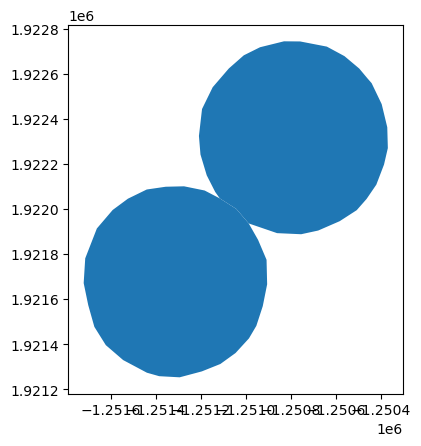

In [5]:
url = "https://services1.arcgis.com/99lidPhWCzftIe9K/arcgis/rest/services/WaterRelatedLandUse/FeatureServer/0/query?where=1%3D1&outFields=*&geometry=-110.75%2C39.438%2C-110.710%2C39.45&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&outSR=5070&f=json"

well_fields = gpd.read_file(url)
well_fields = well_fields[well_fields['OBJECTID'].isin([53384,57425])]
well_fields.plot()

In [19]:
# Get the extent of the shapefile
total_bounds = well_fields.total_bounds

# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = 20
while y <= maxY:
    while x <= maxX:
        geom = shapely.geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:5070')
#fishnet.to_file('fishnet_grid.shp')

In [6]:


# Create a geometry column
df['geometry'] = gpd.points_from_xy(df['X_FETCH_55'], df['Y_FETCH_55'])
df['geometry'].unique()
# Convert the DataFrame to a GeoDataFrame
#gdf = gpd.GeoDataFrame(df, geometry='geometry')

<GeometryArray>
[             <POINT EMPTY>, <POINT (-1251030 1921960)>,
 <POINT (-1250960 1921940)>, <POINT (-1251020 1921940)>,
 <POINT (-1251030 1921920)>, <POINT (-1251020 1921910)>,
 <POINT (-1251040 1921900)>, <POINT (-1251040 1921930)>,
 <POINT (-1251050 1921940)>, <POINT (-1250980 1921980)>,
 ...
 <POINT (-1251050 1922610)>, <POINT (-1251330 1922980)>,
 <POINT (-1251150 1922170)>, <POINT (-1251180 1922190)>,
 <POINT (-1251360 1922010)>, <POINT (-1251570 1922260)>,
 <POINT (-1251680 1922330)>, <POINT (-1252780 1923110)>,
 <POINT (-1251910 1922510)>, <POINT (-1251750 1922450)>]
Length: 4308, dtype: geometry

In [30]:
df

,datetime_start,TIMESTAMP_START,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,FC_SSITC_TEST,LE,...,X_FETCH_MAX,Y_FETCH_MAX,Date,X_FETCH_90,Y_FETCH_90,X_FETCH_55,Y_FETCH_55,X_FETCH_40,Y_FETCH_40,geometry
0,2023-06-14 11:00:00,202306141100,202306141130,-9999.0000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,...,NaN,NaN,2023-06-14,NaN,NaN,NaN,NaN,NaN,NaN,POINT (NaN NaN)
1,2023-06-14 11:30:00,202306141130,202306141200,-9999.0000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,...,NaN,NaN,2023-06-14,NaN,NaN,NaN,NaN,NaN,NaN,POINT (NaN NaN)
2,2023-06-14 12:00:00,202306141200,202306141230,404.8652,7.160377,11.003180,1.408956,-9999.000000,-9999.0,394.658600,...,-1251020.0,1921960.0,2023-06-14,-1251060.0,1921950.0,-1251030.0,1921960.0,-1251030.0,1921960.0,POINT (-1251030 1921960)
3,2023-06-14 12:30:00,202306141230,202306141300,403.2438,6.578680,10.929970,1.396008,-19.724970,-9999.0,277.552900,...,-1250970.0,1921940.0,2023-06-14,-1250930.0,1921920.0,-1250960.0,1921940.0,-1250970.0,1921940.0,POINT (-1250960 1921940)
4,2023-06-14 13:00:00,202306141300,202306141330,397.2703,7.669390,12.208020,1.357026,-29.465460,-9999.0,290.635000,...,-1251010.0,1921940.0,2023-06-14,-1251040.0,1921920.0,-1251020.0,1921940.0,-1251010.0,1921940.0,POINT (-1251020 1921940)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23143,2024-10-08 14:30:00,202410081430,202410081500,401.5762,0.373631,2.863288,0.053154,-0.284607,-9999.0,5.291050,...,-1250990.0,1921870.0,2024-10-08,-1250970.0,1921700.0,-1250980.0,1921830.0,-1250990.0,1921860.0,POINT (-1250980 1921830)
23144,2024-10-08 15:00:00,202410081500,202410081530,401.5929,0.473523,2.466282,0.107060,-0.755953,2.0,0.461339,...,-1251080.0,1921960.0,2024-10-08,-1251220.0,1921960.0,-1251110.0,1921960.0,-1251090.0,1921960.0,POINT (-1251110 1921960)
23145,2024-10-08 15:30:00,202410081530,202410081600,401.3630,0.335989,2.445982,0.044886,-0.116504,-9999.0,4.989396,...,-1251080.0,1921980.0,2024-10-08,-1251230.0,1922030.0,-1251120.0,1921990.0,-1251090.0,1921980.0,POINT (-1251120 1921990)
23146,2024-10-08 16:00:00,202410081600,202410081630,401.1919,0.380539,2.550954,0.069491,-0.942505,2.0,11.713800,...,-1251070.0,1921940.0,2024-10-08,-1251200.0,1921920.0,-1251100.0,1921940.0,-1251080.0,1921940.0,POINT (-1251100 1921940)
